# Tutorial for `MDRefine` - 1b

In these notebooks we are going to perform several different refinements of MD-generated trajectories by employing the package `MDRefine`. In this way, we believe the usage of `MDRefine` will become clear and easy to emulate for your own case of interest. Input data for these examples may be downloaded from Zenodo as indicated in `load_data.ipynb`.

We remind you to have a look at our paper https://arxiv.org/pdf/2411.07798 and at the documentation https://www.bussilab.org/doc-MDRefine/MDRefine/index.html.

Required assistance may be opened at https://github.com/bussilab/MDRefine/issues.

In [1]:
import numpy as np
import jax.numpy as jnp
import pandas
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
# import from parent directory
import sys
sys.path.append('../')

In [3]:
from MDRefine import load_data, minimizer, select_traintest, hyper_minimizer, MDRefinement, unwrap_dict

## 2. Force-field refinement

In this section, we are going to reproduce part of the results presented in *I. Gilardoni et al., "Boosting ensemble refinement with transferable force-field corrections: synergistic optimization for molecular simulations", J. Phys. Chem. Letters 15.5 (2024)* https://pubs.acs.org/doi/full/10.1021/acs.jpclett.3c03423.

In particular, we will focus on fitting a force-field correction to refine structural ensembles of RNA oligomers.

### a. Load data

Load experimental data, observables and forward model as previously done. Also, load force-field correction terms and corresponding functional form.

In [4]:
infos = {}

# Define global properties, valid for all the systems:
infos['global'] = {
    'path_directory': '../../DATA',
    'system_names': ['AAAA','CCCC','GACC','UUUU','UCAAUC'],

    # Then, define properties which are specific of each system, like experimental data and observables
    # If some properties are the same for all the systems, you can store them just once in infos['global']
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs', ('uNOEs','<')],
    'forward_qs': ['backbone1_gamma','backbone2_beta_epsilon','sugar'],
    'obs': ['NOEs','uNOEs'],
    'forward_coeffs': 'original_fm_coeffs'}

# Select the stride for the frames
stride = 1000

In [5]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = np.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [6]:
infos['global']['forward_model'] = forward_model_fun

Now, let's define the force-field correction terms: we selected (for each molecule)
\begin{equation}
\beta\Delta V = \sum_{i}\Bigl[\phi_1\cos\alpha_i + \phi_2\sin\alpha_i + \phi_3 \cos \zeta_i + \phi_4 \sin\zeta_i\Bigr]
\end{equation}
where the sum is over the residues. We can also consider this correction on $\alpha$ dihedral angles only (choose among the following two notebook cells).

Since Numpy arrays `ff_terms` have columns

`['sinalpha[0]', 'sinalpha[1]', 'sinalpha[2]', 'sinzeta[0]', 'sinzeta[1]', 'sinzeta[2]', 'cosalpha[0]', 'cosalpha[1]', 'cosalpha[2]', 'coszeta[0]', 'coszeta[1]', 'coszeta[2]']`,

these two corrections are defined by the following functions (use `jax.numpy`).

In [7]:
# correction on alpha dihedral angles only
def ff_correction_tetramers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,6]]+f[:,[1,7]]+f[:,[2,8]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,10]]+f[:,[1,11]]+f[:,[2,12]]+f[:,[3,13]]+f[:,[4,14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction_tetramers
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha']

In [8]:
# correction on alpha, zeta dihedral angles
def ff_correction_tetramers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,6,3,9]]+f[:,[1,7,4,10]]+f[:,[2,8,5,11]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,10,5,15]]+f[:,[1,11,6,16]]+f[:,[2,12,7,17]]+f[:,[3,13,8,18]]+f[:,[4,14,9,19]]).T)
    return out

infos['global']['ff_correction'] = ff_correction_tetramers
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha', 'sin zeta', 'cos zeta']

In [9]:
# split frames based on "demuxing" (continuous trajectories from temperature replica exchange)
for name_sys in ['AAAA', 'CCCC', 'GACC', 'UUUU']:  # except hexamers
    infos[name_sys] = {'n_temp_replica': 6}

In [10]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done


Now, let's define the **regularization** for the force-field refinement. You can choose among `plain l2` (acting on the coefficients) or `KL divergence` (acting directly on the ensemble).

In [11]:
regularization = {'force_field_reg': 'KL divergence'}

### b. Minimize the loss function and analyse the results
for a single choice of the hyper-parameter $\beta$

Use function `minimizer` with selected data, regularization and beta as input

In [12]:
Result = minimizer(data, regularization=regularization, beta=100)

New evaluation:
loss:  24064.53212180791
gradient:  [-52050.21262097     98.74942183 -49708.76127228   7089.18094194] 

New evaluation:
loss:  9802.125875394182
gradient:  [3401.226793   2810.64478038 2835.8379217  -589.23260553] 

New evaluation:
loss:  173426.33907393014
gradient:  [13280.71821571 -5580.28809276   655.27370387 84805.61354832] 

New evaluation:
loss:  8610.91806860123
gradient:  [4147.77452408 4143.55497631 3168.80681211 -820.70562849] 

New evaluation:
loss:  6581.223873887903
gradient:  [3538.88747935 3947.46115414 3062.17137117 -383.83844263] 

New evaluation:
loss:  100801.46052517442
gradient:  [   132.36875065 -25154.17978261 -29803.07453767 118198.45217355] 

New evaluation:
loss:  5919.285752447281
gradient:  [2299.12788579 1187.91203507 3214.27209554  786.60629866] 

New evaluation:
loss:  33447.59367802112
gradient:  [ 8750.30087889 -1019.37874056  7790.64113674 -1046.03523482] 

New evaluation:
loss:  5615.043766692543
gradient:  [1708.83087328  441.2415302

In [13]:
vars(Result).keys()

dict_keys(['loss', 'pars', 'mini', 'intermediates', 'time', 'reg_ff', 'av_g', 'chi2', 'weights_new', 'logZ_new'])

Besides the same quantities already described in the previous notebook `Tutorial_1.ipynb` (such as: **av_g**, **chi2**, **weights_new**, **logZ_new**), we now have:
- optimal force-field correction parameters **pars**;
- output of minimization **mini**;
- value of force-field regularization **reg_ff**.

In [14]:
Result.pars

array([ 0.70782667, -1.35686344,  0.19536056, -0.15471603])

In [15]:
Result.mini

      fun: 4282.52210988706
 hess_inv: array([[ 1.55323001e-04, -3.91755482e-05, -8.91580302e-05,
        -4.70225832e-06],
       [-3.91755482e-05,  1.99562985e-04, -4.08409220e-07,
         7.11204079e-05],
       [-8.91580302e-05, -4.08409220e-07,  1.30041252e-04,
        -2.13816182e-05],
       [-4.70225832e-06,  7.11204079e-05, -2.13816182e-05,
         1.99025641e-04]])
      jac: array([-2.04681423e-06,  6.49866754e-06, -1.10803335e-04, -6.27979465e-05])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 19
     njev: 27
   status: 0
  success: True
        x: array([ 0.70782667, -1.35686344,  0.19536056, -0.15471603])

In [16]:
Result.reg_ff

{'AAAA': DeviceArray(0.64664231, dtype=float64),
 'CCCC': DeviceArray(0.945109, dtype=float64),
 'GACC': DeviceArray(0.45278288, dtype=float64),
 'UUUU': DeviceArray(0.74349203, dtype=float64),
 'UCAAUC': DeviceArray(1.40301772, dtype=float64)}

### c. Determine optimal hyper parameter $\beta$ through cross validation (scan over $\beta$)

Split the data set with `select_traintest` and minimize the loss function with `minimizer` over different values of the hyperparamter $\beta$ in logarithmic scale.

In [17]:
data_train, data_test, test_obs, test_frames = select_traintest(data, random_state=2, replica_infos=infos)

Input random_state employed both for test_obs and test_frames


In [18]:
log10_betas = np.arange(-2, 7, 0.5)

Results = {}

for log10_beta in log10_betas:
    print(log10_beta)

    beta = 10**np.float64(log10_beta)
    Results[log10_beta] = minimizer(data_train, regularization=regularization, beta=beta, data_test=data_test)

    print(Results[log10_beta].loss)

    clear_output()

In [19]:
# Check the convergence of the minimization
print([Results[log10_beta].mini.success for log10_beta in log10_betas])

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True]


Plot the loss function in training and test, refined coefficients of the force-field correction, the $\chi^2$ and the regularization as a function of the hyperparameter $\beta$.

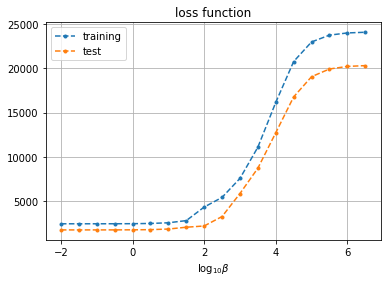

In [20]:
loss = [Results[log10_beta].loss for log10_beta in log10_betas]
loss_test = [Results[log10_beta].loss_test for log10_beta in log10_betas]

plt.title('loss function')
plt.plot(log10_betas, loss, '.--', label = 'training')
plt.plot(log10_betas, loss_test, '.--', label = 'test')
plt.xlabel(r'$\log_{10}\beta$')
plt.legend()
plt.grid()

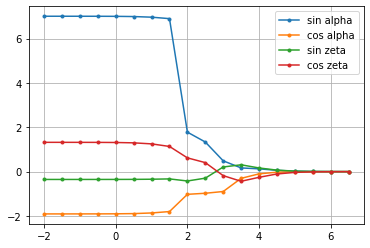

In [21]:
coeffs = np.array([Results[log10_beta].pars for log10_beta in log10_betas]).T

for i in range(len(coeffs)):
    plt.plot(log10_betas, coeffs[i], '.-', label=data.properties.names_ff_pars[i])

plt.legend()
plt.grid()

In [22]:
chi2s = [np.sum(unwrap_dict(Results[log10_beta].chi2)) for log10_beta in log10_betas]
n_obs_train = data_train.properties.tot_n_experiments(data_train)

red_chi2s = np.array(chi2s)/n_obs_train

chi2s_test1 = [np.sum(unwrap_dict(Results[log10_beta].chi2_test)) for log10_beta in log10_betas] # .chi2_test
red_chi2s_test1 = np.array(chi2s_test1)/n_obs_train

chi2s_test2 = [np.sum(unwrap_dict(Results[log10_beta].chi2_new_obs)) for log10_beta in log10_betas] # .chi2_test
n_obs_test = len(unwrap_dict(test_obs))

red_chi2s_test2 = np.array(chi2s_test2)/n_obs_test

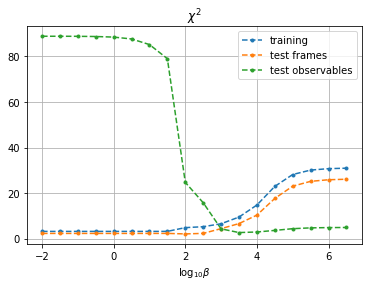

In [23]:
plt.plot(log10_betas, red_chi2s, '.--', label='training')
plt.plot(log10_betas, red_chi2s_test1, '.--', label='test frames')
plt.plot(log10_betas, red_chi2s_test2, '.--', label='test observables')

plt.legend()
plt.title('$\chi^2$')
plt.xlabel(r'$\log_{10}\beta$')
plt.grid()

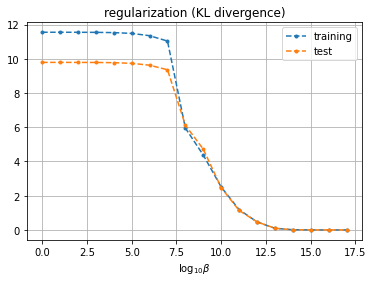

In [24]:
D_KL_train = [np.sum(unwrap_dict(Results[log10_beta].reg_ff)) for log10_beta in log10_betas]
D_KL_test = [np.sum(unwrap_dict(Results[log10_beta].reg_ff_test)) for log10_beta in log10_betas]

plt.title('regularization (KL divergence)')
plt.plot(D_KL_train, '.--', label = 'training')
plt.plot(D_KL_test, '.--', label = 'test')
plt.xlabel(r'$\log_{10}\beta$')
plt.legend()
plt.grid()

### d. Determine optimal hyper parameter $\beta$ through cross validation (automatic optimization)

Let's use `hyper_minimizer` to get the optimal value of the hyperparameter $\beta$. Here, `random_states` can be either a list of values or an integer; if it is an integer, you will take values in `np.arange(random_states)`.

Let's take the same `random_state` used for the scan, so that we can compare the results of `hyper_minimizer` with the previous plot of the $\chi^2$. 

To test the efficiency of the convergence, start from a high $\beta$ value.

In [25]:
starting_beta = 1e5

mini = hyper_minimizer(data, regularization=regularization, starting_beta=starting_beta, random_states=[2])

Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('beta', 5.0)]
New evaluation:
loss:  24080.791788323753
gradient:  [-48169.37303903    -60.64185548 -45165.80792344   7735.83298093] 

New evaluation:
loss:  409363.60957145854
gradient:  [240980.29281427  20117.28378192 256012.08498687  28570.25885698] 

New evaluation:
loss:  23107.03033059067
gradient:  [ 9638.57314415  2082.56453199 10628.94274097  6434.25722805] 

New evaluation:
loss:  29952.536904798
gradient:  [ 17942.88046054 -12986.33695606  -7799.09589193 -50080.81419847] 

New evaluation:
loss:  23000.960163900607
gradient:  [10626.33310026   543.85005193  8568.59801087   -19.62625655] 

New evaluation:
loss:  25915.159792905433
gradient:  [-15040.80308602 -16740.05405045  31621.59456038   -456.80363248] 

New evaluation:
loss:  22997.378981240392
gradient:  [9810.42687881  -49.42751868 9441.43899929  -38.9251702 ] 

New evaluation:
loss:  23020.47627206885
gradient:  [9435.64025678 3533.2348

In [26]:
mini

          fun: DeviceArray(3590.3098896, dtype=float64)
     hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
 intermediate: <MDRefine.hyperminimizer.hyper_minimizer.<locals>.hyper_intermediate_class object at 0x7fda002e77b8>
          jac: array([0.42322092])
      message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
         nfev: 3
          nit: 1
         njev: 3
       status: 0
      success: True
            x: array([0.])

The `intermediate` attribute shows the intermediate steps of the hyperminimization (i.e., the minimization of the $\chi^2$ to search for the optimal hyperparameters)

In [27]:
vars(mini.intermediate)

{'av_chi2': DeviceArray([35762.88492184, 16062.06141342,  3590.3098896 ], dtype=float64),
 'av_gradient': DeviceArray([[1.05959344e+04],
              [1.84031568e+04],
              [4.23220920e-01]], dtype=float64),
 'log10_hyperpars': DeviceArray([[5.],
              [4.],
              [0.]], dtype=float64)}

With the default value `which_set = 'validating'` (namely, minimize the $\chi^2$ on left-out frames but same observables), $\beta$ stops at low values due to the plateau in the figure, and we found $\beta = 1$.

Let's try also with `which_set = 'test'` (left-out observables).

In [28]:
mini2 = hyper_minimizer(data, regularization=regularization, starting_beta=starting_beta, random_states=[2], which_set='test')


Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('beta', 5.0)]
New evaluation:
loss:  24080.791788323753
gradient:  [-48169.37303903    -60.64185548 -45165.80792344   7735.83298093] 

New evaluation:
loss:  409363.60957145854
gradient:  [240980.29281427  20117.28378192 256012.08498687  28570.25885698] 

New evaluation:
loss:  23107.03033059067
gradient:  [ 9638.57314415  2082.56453199 10628.94274097  6434.25722805] 

New evaluation:
loss:  29952.536904798
gradient:  [ 17942.88046054 -12986.33695606  -7799.09589193 -50080.81419847] 

New evaluation:
loss:  23000.960163900607
gradient:  [10626.33310026   543.85005193  8568.59801087   -19.62625655] 

New evaluation:
loss:  25915.159792905433
gradient:  [-15040.80308602 -16740.05405045  31621.59456038   -456.80363248] 

New evaluation:
loss:  22997.378981240392
gradient:  [9810.42687881  -49.42751868 9441.43899929  -38.9251702 ] 

New evaluation:
loss:  23020.47627206885
gradient:  [9435.64025678 3533.2348

In [29]:
mini2

          fun: DeviceArray(1121.76437824, dtype=float64)
     hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
 intermediate: <MDRefine.hyperminimizer.hyper_minimizer.<locals>.hyper_intermediate_class object at 0x7fda00288668>
          jac: array([233.99004215])
      message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
         nfev: 4
          nit: 2
         njev: 4
       status: 0
      success: True
            x: array([3.92474367])

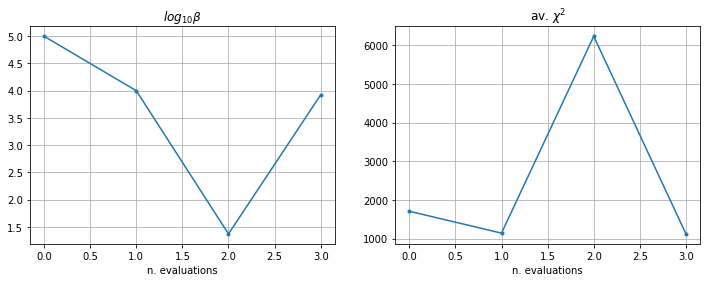

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(mini2.intermediate.log10_hyperpars, '.-')
axs[0].set_title(r'$log_{10} \beta$')
axs[0].set_xlabel('n. evaluations')
axs[0].grid()

axs[1].plot(mini2.intermediate.av_chi2, '.-')
axs[1].set_title(r'av. $\chi^2$')
axs[1].set_xlabel('n. evaluations')
axs[1].grid()

In 4 steps of cross-validation, the automatic `hyper_minimizer` manages to find the optimal solution $\log_{10}\beta \simeq 3.9$, in agreement with the previous plot of the $\chi^2$.

Now, let's try with multiple random states in order to get more robust results. Let's use 2 random states `random_states = [0, 1]`. The function `hyper_minimizer` cycles over the selected choices of training/test set (given by `random_states`) and minimize the average $\chi^2$ over left-out observables or frames (depending on `which_set`, let's take the default choice `which_set = 'validation'`, for instance).

In [31]:
mini = hyper_minimizer(data, regularization=regularization, starting_beta=starting_beta, random_states=2)

Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('beta', 5.0)]
av. chi2:  35723.67342935669
av. gradient:  [10391.82897007]

log10 hyperpars:  [('beta', 4.0)]
av. chi2:  15892.243971478596
av. gradient:  [19637.92762065]

log10 hyperpars:  [('beta', 0.0)]
av. chi2:  16700.233536544074
av. gradient:  [2012.34013365]

log10 hyperpars:  [('beta', -1.2007535142846528)]
av. chi2:  15919.418185080267
av. gradient:  [114.75168068]


In [32]:
print(mini)

print('\n\nintermediate steps:')
print(vars(mini.intermediate))

          fun: DeviceArray(15919.41818508, dtype=float64)
     hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
 intermediate: <MDRefine.hyperminimizer.hyper_minimizer.<locals>.hyper_intermediate_class object at 0x7fda0022cc50>
          jac: array([114.75168068])
      message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
         nfev: 4
          nit: 2
         njev: 4
       status: 0
      success: True
            x: array([-1.20075351])


intermediate steps:
{'av_chi2': DeviceArray([35723.67342936, 15892.24397148, 16700.23353654,
             15919.41818508], dtype=float64), 'av_gradient': DeviceArray([[10391.82897007],
             [19637.92762065],
             [ 2012.34013365],
             [  114.75168068]], dtype=float64), 'log10_hyperpars': DeviceArray([[ 5.        ],
             [ 4.        ],
             [ 0.        ],
             [-1.20075351]], dtype=float64)}


In [33]:
opt_beta = 10**mini.x[0]

print(opt_beta)

0.0629863563226224


In [34]:
result = minimizer(data, regularization=regularization, beta=opt_beta)

New evaluation:
loss:  24064.53212180791
gradient:  [-52050.21262097     98.74942183 -49708.76127228   7089.18094194] 

New evaluation:
loss:  9406.753073351712
gradient:  [3168.30874375 2792.26416641 2583.83225739 -619.79743775] 

New evaluation:
loss:  190342.13295834372
gradient:  [ 9.04401485e+03 -3.52847465e+03  3.03054382e+01  5.30081385e+04] 

New evaluation:
loss:  8350.793332538442
gradient:  [3867.84894572 4033.82188337 2889.31857734 -837.83366467] 

New evaluation:
loss:  6484.239630258074
gradient:  [3611.62241612 4482.23956301 2844.1838928  -609.1126878 ] 

New evaluation:
loss:  116248.4843606913
gradient:  [ -5002.63878681 -28432.61329061 -37418.87071621 110931.24523379] 

New evaluation:
loss:  5538.19618795307
gradient:  [2403.73863793 2039.51976854 2898.93210359  501.50502146] 

New evaluation:
loss:  28951.966263034563
gradient:  [ 4887.77217461 -3383.31106324   931.75743275 -4751.75046329] 

New evaluation:
loss:  5167.401468500827
gradient:  [1571.29171247  437.879

In [35]:
vars(result)

{'loss': DeviceArray(3850.51394401, dtype=float64),
 'pars': array([ 0.73588997, -1.42174398,  0.2064404 , -0.17941788]),
 'mini':       fun: 3850.513944010212
  hess_inv: array([[ 1.36532059e-04, -3.81231642e-05, -7.04745642e-05,
         -1.65470507e-05],
        [-3.81231642e-05,  2.05313315e-04, -9.68140643e-06,
          7.33264139e-05],
        [-7.04745642e-05, -9.68140643e-06,  1.16673198e-04,
         -1.95578780e-05],
        [-1.65470507e-05,  7.33264139e-05, -1.95578780e-05,
          1.86633447e-04]])
       jac: array([ 4.95299139e-04,  2.79473403e-05, -1.18956411e-04,  6.62337766e-04])
   message: 'Optimization terminated successfully.'
      nfev: 28
       nit: 20
      njev: 28
    status: 0
   success: True
         x: array([ 0.73588997, -1.42174398,  0.2064404 , -0.17941788]),
 'intermediates': <MDRefine.loss_and_minimizer.intermediates_class at 0x7fda001ccf60>,
 'time': 60.17764639854431,
 'reg_ff': {'AAAA': DeviceArray(0.67976714, dtype=float64),
  'CCCC': Device

This can be automatically done with `MDRefinement` and the output results will be saved in the directory whose default path name is `results`

In [36]:
my_results = MDRefinement(infos, stride=stride, regularization=regularization, starting_beta=starting_beta, random_states=2)

loading data from directory...
loading  AAAA
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done

search for optimal hyperparameters ...
Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('beta', 5.0)]
av. chi2:  3699.8222172385713
av. gradient:  [-10.40679213]

log10 hyperpars:  [('beta', 6.0)]
av. chi2:  3708.6204802919824
av. gradient:  [5.85768408]

log10 hyperpars:  [('beta', 5.142044337171247)]
av. chi2:  3699.7161573743965
av. gradient:  [6.46024395]

optimal hyperparameters: beta: 138689.74101533176 

refinement with optimal hyperparameters...
New evaluation:
loss:  24064.532121808807
gradient:  [-52050.21262097     98.74942183 -49708.76127228   7089.18094194] 

New evaluation:
loss:  558093.6171034691
gradient:  [326405.19646228  28300.34511155 352309.95644097  41797.18687903] 

New evaluation:
loss:  23265.464089721885
gradient:  [13166.52216185  2682.25515004 13234.908779

In [37]:
vars(my_results).keys()

dict_keys(['loss', 'pars', 'mini', 'intermediates', 'time', 'reg_ff', 'av_g', 'chi2', 'weights_new', 'logZ_new', 'optimal_hyperpars', 'hyper_minimization'])

In [38]:
vars(my_results.hyper_minimization.intermediate)

{'av_chi2': DeviceArray([3699.82221724, 3708.62048029, 3699.71615737], dtype=float64),
 'av_gradient logbeta': DeviceArray([-10.40679213,   5.85768408,   6.46024395], dtype=float64),
 'log10_hyperpars beta': DeviceArray([5.        , 6.        , 5.14204434], dtype=float64)}